# Aprendizado Profundo: CNNs

**Dataset:** On Vehicle Helmet Detection Dataset

**Problema:** Classificação de Segurança no Trânsito (Uso de Capacete)

O objetivo deste projeto é desenvolver um modelo de Redes Neurais Convolucionais (CNN) capaz de identificar automaticamente se motociclistas estão utilizando capacete de segurança.

Este problema é de alta relevância para sistemas de cidades inteligentes e segurança do trabalho, permitindo a automação da fiscalização e prevenção de acidentes fatais. O dataset utilizado contém imagens reais capturadas em ambiente de trânsito, divididas em classes de "Com Capacete" e "Sem Capacete".

Importação das bibliotecas

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import pathlib
import kagglehub
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential

try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

print("Bibliotecas importadas !!!")

Bibliotecas importadas !!!


2025-12-01 20:55:52.193422: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 1. Processamento dos Dados
Nesta etapa, realizamos o carregamento e pré-processamento das imagens:
1. **Redimensionamento:** Todas as imagens foram padronizadas para o tamanho 128x128 pixels.
2. **Divisão:** O conjunto foi dividido em 80% para treino e 20% para validação.
3. **Batching:** As imagens são processadas em lotes (batches) de 32.

In [2]:
print("Baixando/Verificando o dataset do Kaggle...")
path_root = kagglehub.dataset_download("rajeevsekar21/on-vehicle-helmet-detection-dataset")

data_dir = pathlib.Path(path_root) / 'Helmet_Dataset'

print(f"Diretório: {data_dir}")

try:
    print(f"Classes (pastas) encontradas: {os.listdir(data_dir)}")
except Exception as e:
    print(f"Erro ao ler diretório: {e}")

batch_size = 32
img_height = 128
img_width = 128

print("\n--- Carregando treino...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("--- Carregando validação...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(f"\n --- CLASSES FINAIS: {class_names} ---")

Baixando/Verificando o dataset do Kaggle...
Diretório: /home/biabenigno/.cache/kagglehub/datasets/rajeevsekar21/on-vehicle-helmet-detection-dataset/versions/1/Helmet_Dataset
Classes (pastas) encontradas: ['Helmet', 'Person_no_helmet', 'no_person']

--- Carregando treino...
Found 672 files belonging to 3 classes.
Using 538 files for training.
--- Carregando validação...
Found 672 files belonging to 3 classes.
Using 134 files for validation.

 --- CLASSES FINAIS: ['Helmet', 'Person_no_helmet', 'no_person'] ---


Visualizando 9 imagens do dataset:

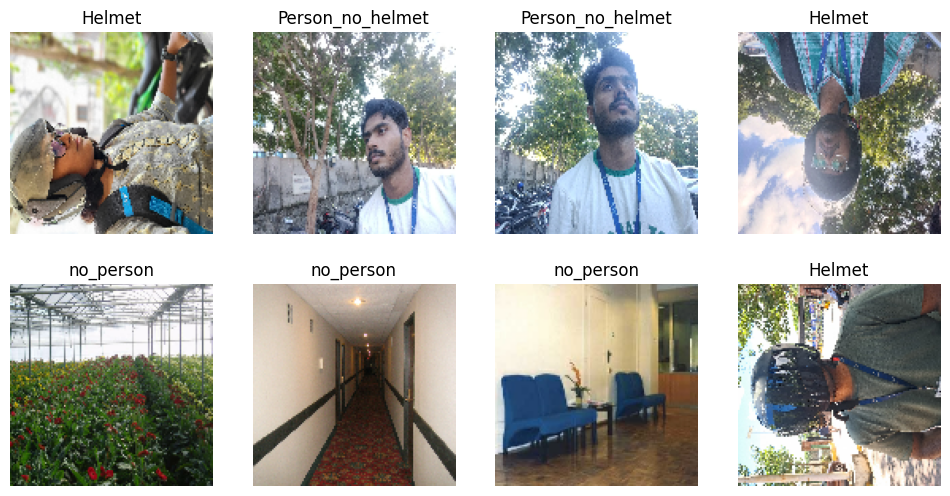

In [3]:
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

## 3. Treinamento e Avaliação

### Arquitetura da Rede
Utilizamos uma arquitetura Rede Neural Convolucional (CNN) Sequencial com as seguintes características:
* **Rescaling:** Normalização dos pixels (0 a 1).
* **Data Augmentation:** Rotação e espelhamento aleatórios para evitar overfitting.
* **Camadas Convolucionais (Filtros):** 3 blocos para extração de características visuais.
* **MaxPooling:** Para redução de dimensionalidade.
* **Dense/Dropout:** Camadas finais para classificação e regularização.

In [4]:
num_classes = len(class_names)

model = models.Sequential([
  Input(shape=(img_height, img_width, 3)),
  
  layers.Rescaling(1./255),

  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("Modelo CNN criado !!!")

Modelo CNN criado !!!


Treinamento:

In [5]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print("Treinamento concluído !!")
acc_final = history.history['val_accuracy'][-1]
loss_final = history.history['val_loss'][-1]
print(f"Acuracia: {acc_final*100:.2f}% ({acc_final:.6f})")
print(f"Loss: {loss_final:.6f}")

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - accuracy: 0.3606 - loss: 1.1303 - val_accuracy: 0.4104 - val_loss: 1.0314
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - accuracy: 0.4777 - loss: 0.9969 - val_accuracy: 0.5522 - val_loss: 0.9530
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.5353 - loss: 0.9456 - val_accuracy: 0.4552 - val_loss: 1.0330
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.5967 - loss: 0.8649 - val_accuracy: 0.4627 - val_loss: 1.2957
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.6171 - loss: 0.8134 - val_accuracy: 0.6716 - val_loss: 0.7706
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 559ms/step - accuracy: 0.6691 - loss: 0.7216 - val_accuracy: 0.5821 - val_loss: 0.7392
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.6691 - loss: 0.6826 - val_accuracy: 0.7463 - val_loss: 0.7193
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step - accuracy: 0.7230 - loss: 0.6484 - val_accu

## 4. Resultados Obtidos
Abaixo apresentamos os gráficos de desempenho do modelo.
* **Acurácia:** Indica a porcentagem de acertos.
* **Loss (Perda):** Indica o erro do modelo (quanto menor, melhor).

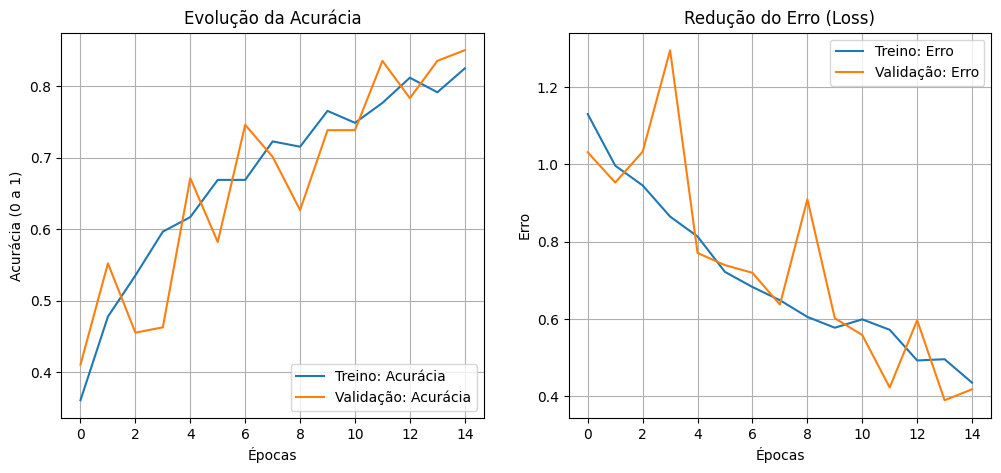

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino: Acurácia')
plt.plot(epochs_range, val_acc, label='Validação: Acurácia')
plt.legend(loc='lower right')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (0 a 1)')
plt.grid(True)

# Erro (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino: Erro')
plt.plot(epochs_range, val_loss, label='Validação: Erro')
plt.legend(loc='upper right')
plt.title('Redução do Erro (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.grid(True)

plt.show()

* **Matriz de Confusão:** Uma tabela que cruza as previsões do modelo com a realidade.
* **Precision (Precisão):** Indica a confiabilidade.
* **Recall (Revocação):** Indica a sensibilidade. De todos os capacetes que existem, quantos o modelo conseguiu encontrar?
* **F1-Score:** É uma média equilibrada entre Precision e Recall. É a melhor métrica para dizer se o modelo é robusto de verdade.

Gerando previsões para calcular métricas...


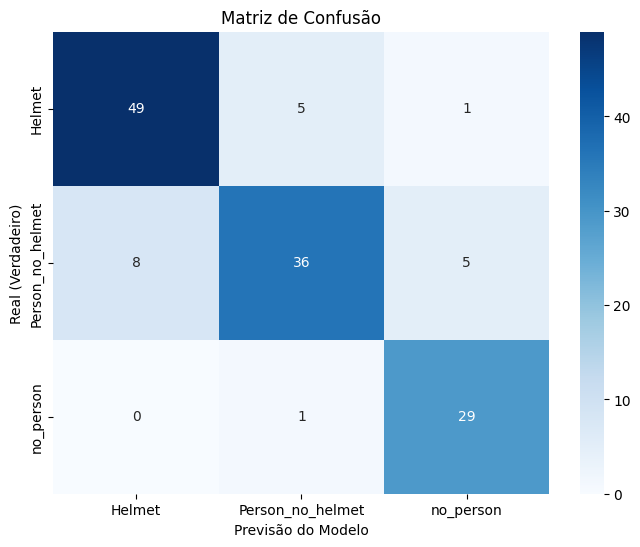


--- Relatório de Classificação ---
                  precision    recall  f1-score   support

          Helmet       0.86      0.89      0.88        55
Person_no_helmet       0.86      0.73      0.79        49
       no_person       0.83      0.97      0.89        30

        accuracy                           0.85       134
       macro avg       0.85      0.86      0.85       134
    weighted avg       0.85      0.85      0.85       134



In [7]:
print("Gerando previsões para calcular métricas...")
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Real (Verdadeiro)')
plt.title('Matriz de Confusão')
plt.show()

print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))

Abaixo, interpretamos as métricas para cada classe específica, o que nos ajuda a entender os pontos fortes e fracos do modelo:

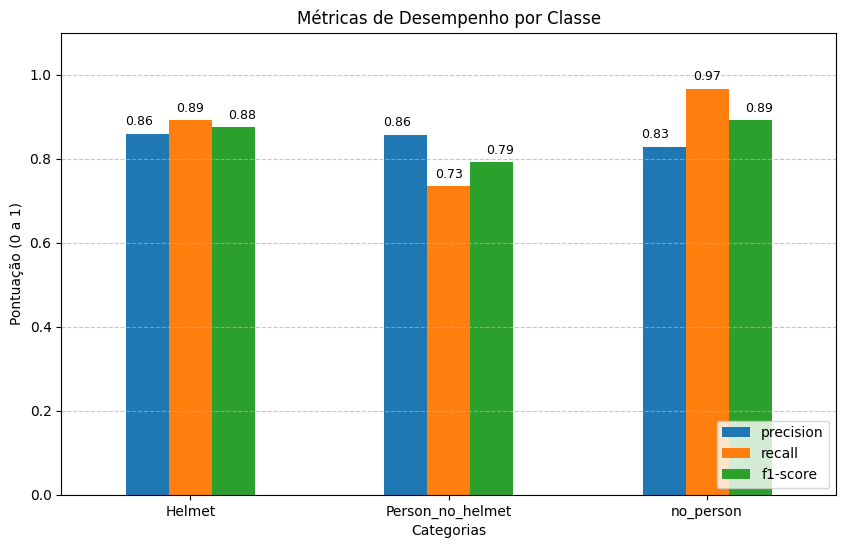

In [8]:
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

df_metrics = pd.DataFrame(report_dict).transpose()
classes_metrics = df_metrics.iloc[:-3, :3] 

classes_metrics.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Métricas de Desempenho por Classe")
plt.xlabel("Categorias")
plt.ylabel("Pontuação (0 a 1)")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1) 

for i, col in enumerate(classes_metrics.columns):
    for j, val in enumerate(classes_metrics[col]):
        plt.text(j + (i-1)*0.2, val + 0.02, f"{val:.2f}", ha='center', fontsize=9)

plt.show()